<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0620_ImageSegmentation_UNet_TensorFlow_229_240ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7. 이미지 분할
- 이미지 분할 또는 세그멘테이션은 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것이다.
- 모든 픽셀은 어떤 클래스(배경/객체)에 속한다.

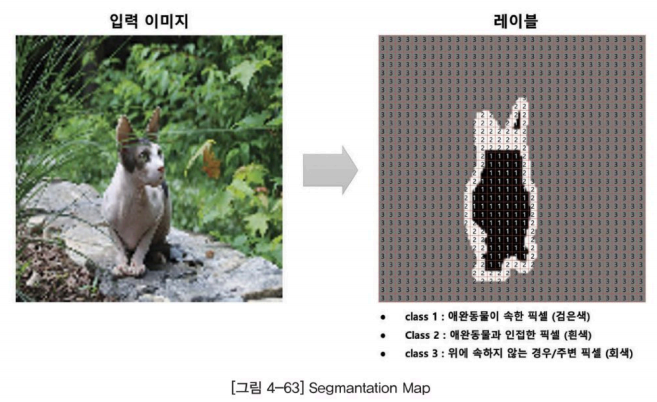

- 이미지 분할
>- 의미 분할(semantics segmentation) : 여러 객체를 하나의 범주로 묶어서 구분
>- 인스턴스 분할(instance segmentation) : 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념이다.


### 데이터셋 준비
- 이 데이터셋은 반려동물의 이미지 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성되어 있다.
- 마스크 : 각 픽셀에 대한 범주 레이블

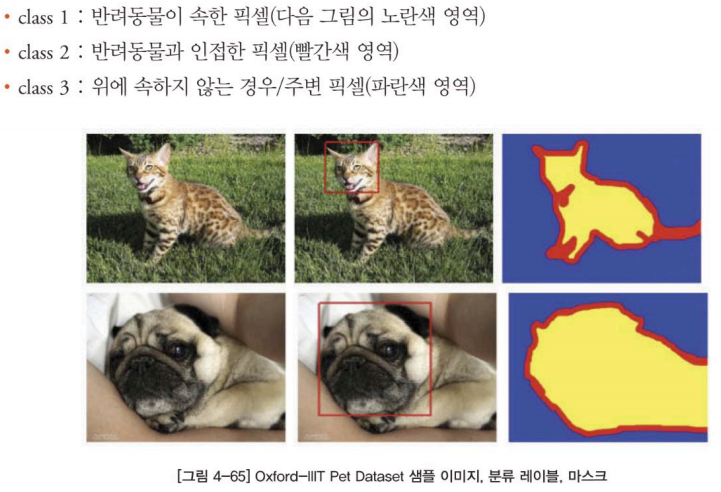

-

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2    # OpenCV는 영상처리 라이브러리
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [ ]:
# 학습 파라미터 설정

# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 2
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

In [ ]:
# 이미지 전처리 함수 - 원본 이미지와 분할 마스크에 적용한다
def preprocess_image(ds):
  #원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h)) # 이미지 크기를 사전에 정한 128X128 크기로 변경
  img = tf.cast(img, tf.float32) / 255.0  # 자료형 변환 및 정규화
  #분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

In [ ]:
# 데이터 전처리 파이프라인
## 앞에서 정의한 전처리 함수를 훈련 셋과 테스트 셋에 매핑 => 미니배치 분할
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [ ]:
# 샘플 배치 한 개 선택. 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어 있다.
img, mask = next(iter(train_ds))
len(img)

16

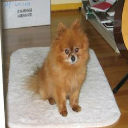

In [ ]:
# 샘플 이미지 출력
img = np.array(img[0])*255.0 # 정규화 이전의 값으로 복원
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

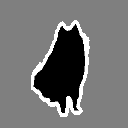

In [ ]:
# 샘플 마스크 출력 - 마스크 이미지 출력
mask = (np.array(mask[0])/2)*255.0 # 마스크 값의 범위는 0~2이므로 2로 나눈후 255 곱해 RGB이미지로 표
cv2_imshow(mask)

## U-Net모델(인코더-디코더)

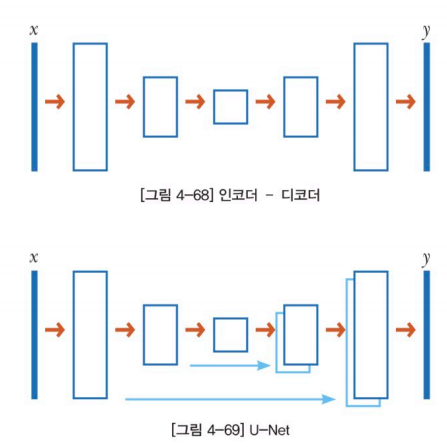


In [ ]:
# VGG16 모델 - 최종 레이어를 제외한 채 불러오기(이후 pretrained parameter 적용하여 전이학습하기 위함)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top = False)

58889256/58889256 [==============================] - 1s 0us/step


- VGG16모델은 합성곱 층과 풀링층을 직렬로 연결한 구조이다. 처음에는 (128,128) 크기의 텐서가 마지막 레이어에서는 (4,4) 크기로 축소된다.
- 인코더는 원본 이미지 중에서 같은 범주에 있는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소한다.
- 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2 중에서 하나로 분류하는 역할을 한다.

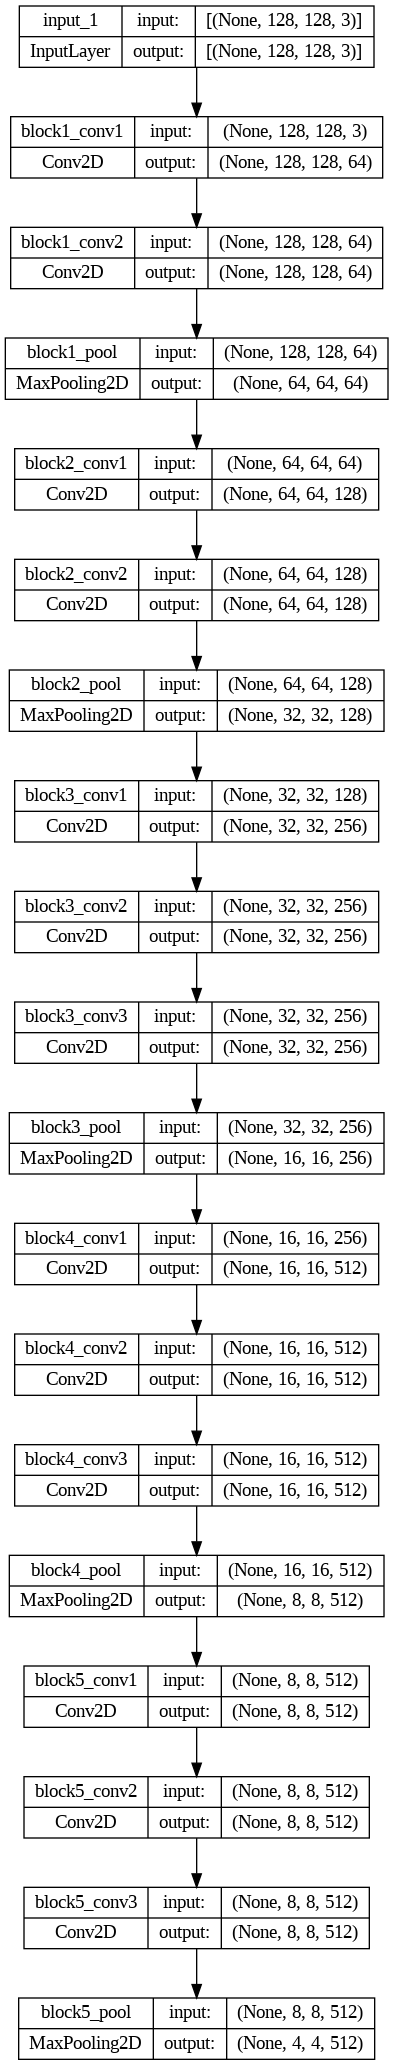

In [ ]:
# 모델 구조 - U-Net의 인코더
tf.keras.utils.plot_model(base_model, show_shapes=True)

- 만들고자 하는 U-net의 모양을 미리 정하고 pre-train된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 정한다.
- VGG16모델의 중각 레이어 중에서 필요한 출력 텐서를 지정하여 다양한 피처(특징)을 추출하는 인코더 모델을 정의한다.

In [ ]:
# VGG16 중간 레이어 출력 텐서를 지정
## VGG모델로부터 5개의 출력을 가져와서 사용한다.
## 새로운 Feature Extractor모델을 정의하고 f_model 변수에 저장
f_model = tf.keras.Model(inputs=[base_model.input], # 1개 입력
                         outputs=[
                             base_model.get_layer(name='block5_conv3').output,
                             base_model.get_layer(name='block4_conv3').output,
                             base_model.get_layer(name='block3_conv3').output,
                             base_model.get_layer(name='block2_conv2').output,
                             base_model.get_layer(name='block1_conv2').output
                         ]) # 5개 출력

In [ ]:
# 파라미터 고정
f_model.trainable = False # pre-train된 파라미터를 인코더에 그대로 사용하기 위해 업데이트되지 않도록 고정한다.

- 인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링한다.
- Upsampling은 축소된 이미지를 원래 이미지 크기로 복원하는 과정을 말한다.
- 제일 작은 (8,8,512) 텐서에서 시작해서 조금씩 크기를 키워 나가며 중간 출력과 합친다.

In [ ]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3,3,activation='elu',padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

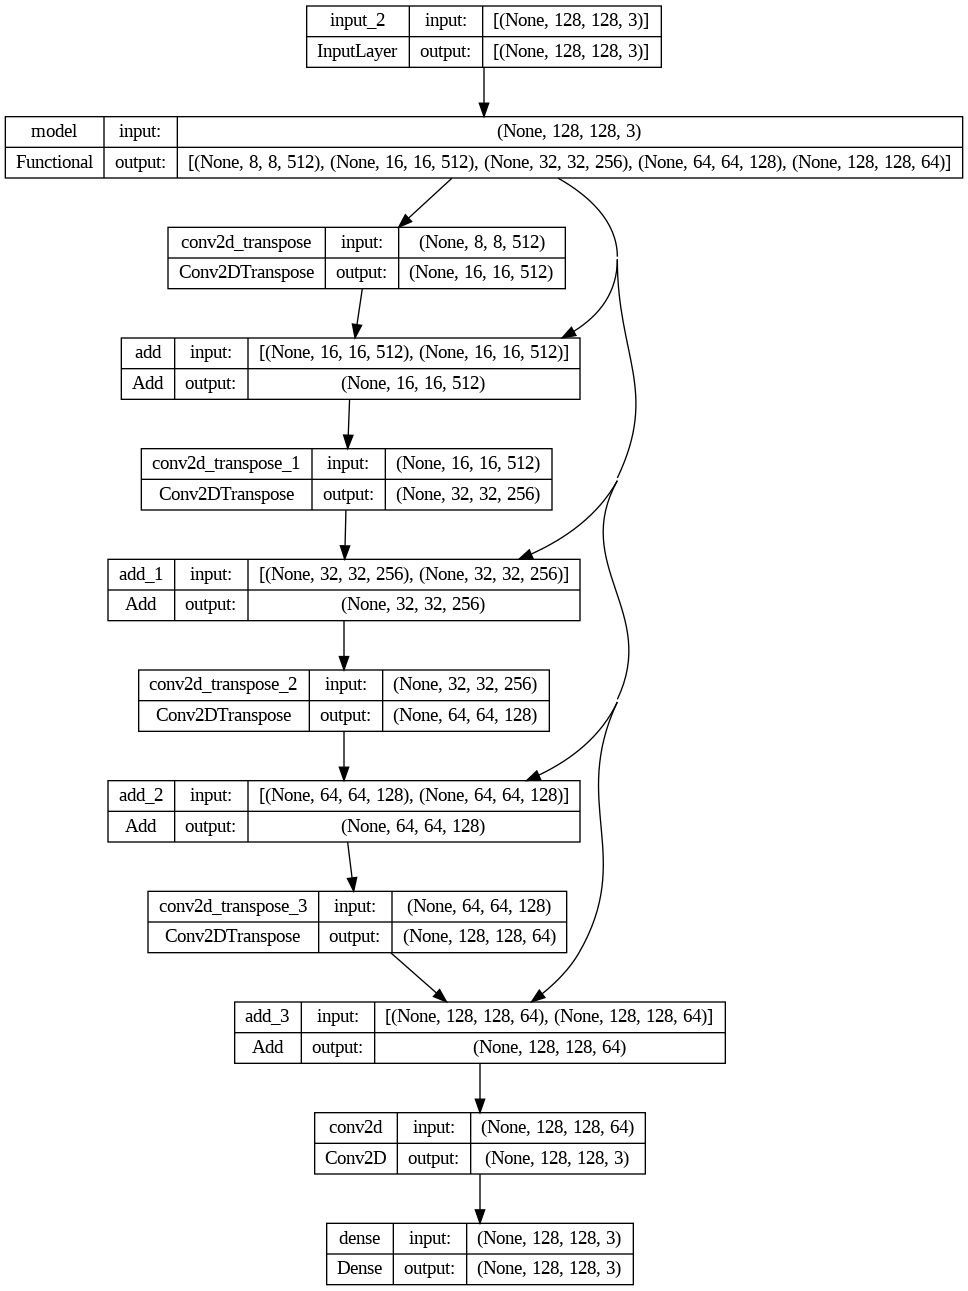

In [ ]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

위 구조를 다음과 같이 시각화가 가능하다. 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것을 확인할 수 있다.

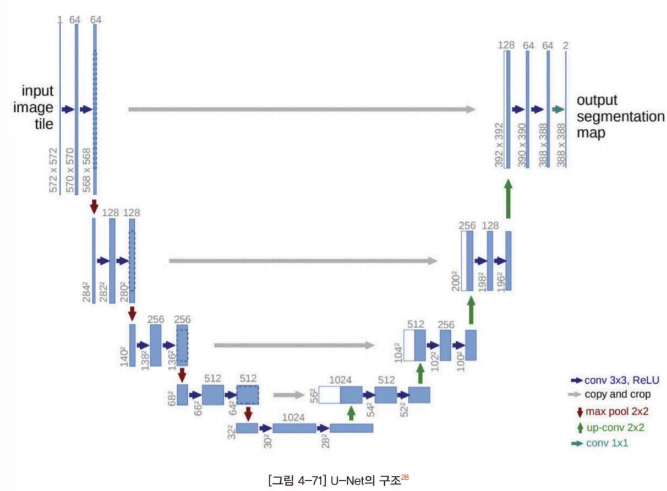

In [ ]:
# 모델 요약
unet_model.summary()
# f_model로부터 유래하는 5개 레이어의 14714688개의 파라미터는 학습되지 않도록 고정되어 있다

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

In [ ]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy() # 다중 분류이므로 SparseCategoricalCrossentropy
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/2
230/230 [==============================] - 1285s 6s/step - loss: 0.5686 - accuracy: 0.8143
Epoch 2/2
230/230 [==============================] - 1275s 6s/step - loss: 0.4983 - accuracy: 0.8351


1/1 [==============================] - 4s 4s/step


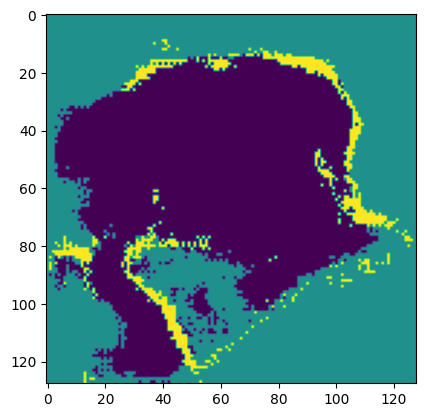

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds)) # 검증 셋의 배치 하나 선택

# 모델 예측
pred = unet_model.predict(img) # 이미지 분할 클래스 예측

# 첫 번쨰 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1) # 배치를 구성하는 16개 이미지 중에서 첫번째 이미지의 분할 결과를 노트북에 출력
plt.imshow(pred_img)

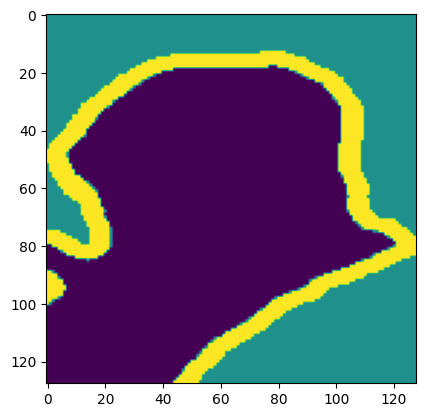

In [ ]:
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128))) # 정답 마스크 이미지